In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from dotenv import load_dotenv
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()

True

In [4]:
try:
    conn = mysql.connector.connect(
    host= 'localhost',
    user = os.getenv('db_user'),
    password = os.getenv('db_pass')
    )
    print('Connection established!')
except mysql.connector.Error as e:
    print(f'Error: {e}')

Connection established!


In [5]:
# Create a cursor
cursor = conn.cursor(buffered=True)

In [6]:
cursor.execute('use zomato')

In [7]:
zomato = pd.read_sql_query('Show tables',conn)
zomato

,Tables_in_zomato
0,goldusers_signup
1,product
2,sales
3,users


In [8]:
# Creating a function to execute SQL query and return result as dataframe

def sql_to_df(query, conn, df_name=None):
    """
    Execute a SQL query using pd.read_sql_query and return the result as a DataFrame.

    Args:
        query (str): The SQL query to execute.
        conn: The database connection object.
        df_name (str, optional): A name to assign to the resulting DataFrame.

    Returns:
        pd.DataFrame or None: The result of the SQL query as a DataFrame, or None if an error occurs.
    """
    try:
        result_df = pd.read_sql_query(query, conn)
        if df_name:
            globals()[df_name] = result_df
        return result_df
    except Exception as e:
        print(f"Error executing SQL query: {str(e)}")
        return None


## Question 1: What is the total amount each customer spent on Zomato?

In [9]:
query1 = '''select a.userid, sum(b.price) as Amount
from sales a
inner join product b on a.product_id =  b.product_id
group by a.userid
order by a.userid;'''

sql_to_df(query=query1, conn= conn, df_name='total_amount_spent')

,userid,Amount
0,1,5230.0
1,2,2510.0
2,3,4570.0


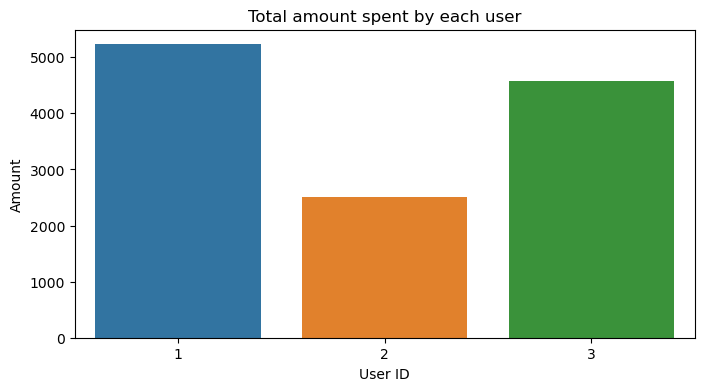

In [10]:
plt.figure(figsize=(8,4))
sns.barplot(data=total_amount_spent, x='userid', y='Amount')
plt.title('Total amount spent by each user')
plt.xlabel('User ID')
plt.ylabel('Amount')
plt.show()

## Question 2:How many days has each customer visited zomato?

In [11]:
query2 = '''select userid, count(distinct(created_date)) as Total_Counts
from sales
group by userid;'''

sql_to_df(query=query2, conn=conn, df_name='dayvisits_per_user')

,userid,Total_Counts
0,1,7
1,2,4
2,3,5


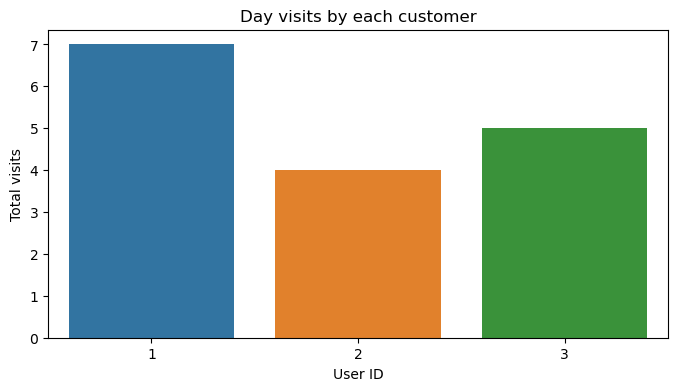

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(data=dayvisits_per_user, x='userid', y='Total_Counts')
plt.title('Day visits by each customer')
plt.xlabel('User ID')
plt.ylabel('Total visits')
plt.show()

## Question 3: What was the first product purchased by each customer?

In [13]:
query3 = '''select s.userid, s.product_id, s.product_name from
(select a.userid, a.created_date, a.product_id, b.product_name, dense_rank() over(partition by a.userid order by created_date) as rnk
from sales a
inner join product b on a.product_id = b.product_id)s
where rnk = 1;'''

sql_to_df(query=query3, conn=conn, df_name='first_product_purchase')

,userid,product_id,product_name
0,1,1,p1
1,2,1,p1
2,3,1,p1


## Question 4: What is most purchased item on menu & how many times was it purchased by all customers?

In [14]:
query4 = '''select a.product_id, b.product_name, count(a.product_id) as Total_count
from sales a
inner join product b on a.product_id = b.product_id
group by a.product_id, b.product_name
order by Total_count desc
limit 1;'''

sql_to_df(query=query4, conn=conn, df_name='most_purchased_item')

,product_id,product_name,Total_count
0,2,p2,7


## Question 5: Which item was most popular product for each customer?

In [15]:
query5 = '''select s.userid, s.product_name, s.Total_count from
(select a.userid, b.product_name, count(a.product_id) as Total_count, dense_rank() over(partition by userid order by count(a.product_id) desc) as rnk
from sales a
inner join product b on a.product_id = b.product_id
group by a.userid, b.product_name) s
where rnk = 1;'''

sql_to_df(query5, conn, 'popular_product_per_customer')

,userid,product_name,Total_count
0,1,p2,3
1,2,p3,2
2,3,p2,3


## Question 6: Which item was purchased first by the customer after they become a gold member?

In [16]:
query6 = '''select d.userid, d.product_id, d.product_name from 
(select a.*, b.product_name, row_number() over(partition by a.userid order by a.created_date) as rn
from sales a
inner join product b on a.product_id = b.product_id
inner join goldusers_signup c on a.userid = c.userid
where a.created_date >= c.gold_signup_date) d
where d.rn = 1;'''

sql_to_df(query6, conn, 'first_purchase_after_gold')

,userid,product_id,product_name
0,1,3,p3
1,3,2,p2


## Question 7: Which item was purchased by the customer just before they become a gold member?

In [17]:
query7 = '''select d.userid, d.product_id, d.product_name from 
(select a.*, b.product_name, row_number() over(partition by a.userid order by a.created_date desc) as rn
from sales a
inner join product b on a.product_id = b.product_id
inner join goldusers_signup c on a.userid = c.userid
where a.created_date < c.gold_signup_date) d
where d.rn = 1;'''

sql_to_df(query7, conn, 'puchaser_before_gold')

,userid,product_id,product_name
0,1,2,p2
1,3,2,p2


## Question 8: What is the total orders and amount spent for each customer before they became a gold member?

In [18]:
query8 = '''select a.userid, count(a.product_id) as Total_orders, sum(b.price) as Amount
from sales a
inner join product b on a.product_id = b.product_id
inner join goldusers_signup c on a.userid = c.userid
where a.created_date < c.gold_signup_date
group by a.userid
order by a.userid;'''

sql_to_df(query8, conn, 'total_orders_amount_before_gold')

,userid,Total_orders,Amount
0,1,5,4030.0
1,3,3,2720.0


## Question 9: If buying each product generates points for eg 5rs=2 zomato point and each product has different purchasing points for eg for p1 5rs=1 zomato point, for p2 10rs=5 zomato point and p3 5rs=1 zomato point. Calculate points collected by each customer and for which product most points have been given till now.

##### The following query is for calculating the total points earned by each user

In [19]:
query9_a = '''select e.userid, sum(Total_points) as Final_points from
(select d.*, round(d.Price/d.points) as Total_points from
(select c.*, case when c.product_id = 1 then 5
				  when c.product_id = 2 then 2
                  when c.product_id = 3 then 5 end as Points
from                 
(select a.userid, a.product_id, sum(b.price) as Price
from sales a
inner join product b on a.product_id = b.product_id
group by a.userid, a.product_id) c) d) e
group by e.userid
order by e.userid;'''

sql_to_df(query9_a, conn, 'total_points_per_customer')

,userid,Final_points
0,1,1829.0
1,2,763.0
2,3,1697.0


##### The following query is to find out the product that has received the highest number of points up to this point?"

In [20]:
query9_b = '''select e.product_id, sum(e.Total_points) as Final_points from
(select d.*, round(d.Price/d.points) as Total_points from
(select c.*, case when c.product_id = 1 then 5
				  when c.product_id = 2 then 2
                  when c.product_id = 3 then 5 end as Points
from                 
(select a.userid, a.product_id, sum(b.price) as Price
from sales a
inner join product b on a.product_id = b.product_id
group by a.userid, a.product_id) c) d) e
group by e.product_id
order by Final_points desc
limit 1;'''

sql_to_df(query9_b, conn, 'most_points_product')

,product_id,Final_points
0,2,3045.0


## Question 10: In the first year of a customer joining the gold program (including the joining date), irrespective of what customer has purchased,he earn 5 zomato points for every 10rs spent. Which user earned more and what was their points earning in the first year?

##### Note for solution: 10rs = 5 zomato points means that 1 point = 2rs

In [21]:
query10 = '''select f.userid, sum(f.Points) as Total_points from
(select e.*, round(e.price/2) as Points from
(select d.userid, d.product_id, sum(d.price) as Price from
(select a.*, b.product_name, b.price, c.gold_signup_date
from sales a
inner join product b on a.product_id = b.product_id
inner join goldusers_signup c on a.userid = c.userid
where a.created_date >= c.gold_signup_date and a.created_date <= date_add(c.gold_signup_date, interval 1 year)) d
group by d.userid, d.product_id) e) f
group by f.userid
order by Total_points desc;'''

sql_to_df(query10, conn, 'points_in_first_gold_year')

,userid,Total_points
0,3,435.0
1,1,165.0


## Question 11:  Rank all transactions of each customer by the price of the product from highest to lowest.

In [22]:
query11 = '''select a.userid, a.product_id, sum(b.price) as Price, dense_rank() over(partition by a.userid order by sum(b.price) desc) as Rnk
from sales a
inner join product b on a.product_id = b.product_id
group by a.userid, a.product_id;'''

sql_to_df(query11, conn, 'customer_transactions_rank')

,userid,product_id,Price,Rnk
0,1,2,2610.0,1
1,1,1,1960.0,2
2,1,3,660.0,3
3,2,1,980.0,1
4,2,2,870.0,2
5,2,3,660.0,3
6,3,2,2610.0,1
7,3,1,1960.0,2


## Question 12: Rank all transactions for each customer when they are zomato gold member. When they are a non-gold member then mark their transaction as 'NA'.

In [23]:
query12 = '''select c.*, case when c.gold_signup_date is not null then dense_rank() over(partition by c.userid order by c.created_date)
				 else 'NA' end as Rnk
from
(select a.*, b.gold_signup_date
from sales a
left join goldusers_signup b on a.userid = b.userid) c;'''

sql_to_df(query12, conn, 'gold_non_gold_customer_rank')

,userid,created_date,product_id,gold_signup_date,Rnk
0,1,2016-03-11,1,2017-09-22,1
1,1,2016-05-20,3,2017-09-22,2
2,1,2016-11-09,1,2017-09-22,3
3,1,2017-03-11,2,2017-09-22,4
4,1,2017-04-19,2,2017-09-22,5
5,1,2018-03-19,3,2017-09-22,6
6,1,2019-10-23,2,2017-09-22,7
7,2,2017-09-24,1,None,NA
8,2,2017-11-08,2,None,NA
9,2,2018-09-10,3,None,NA
